# Contents

[**1. Get the relevant data from SQL DB**](#get_data)

[**2. Clean the data**](#clean_data)

[**3. Bag of words, TF-IDF and similarity**](#bow)

[**4. Generate the learning curve**](#learning_curve)

[**5. Slackbot**](#slackbot)

---

In [1]:
import psycopg2, nltk, gensim, subprocess, re, time, sys, os
import pandas as pd
import numpy as np

from slackclient import SlackClient
from __future__ import division

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # For pretty plots
%config InlineBackend.figure_format='retina'

---

# <a name="get_data">1. Get the relevant data from SQL DB</a>

Open my Postgres app

In [2]:
# subprocess.call(["/usr/bin/open", "-n", "-a", "/Applications/Postgres.app"]);

Connect to DB and pull the comments from all the subreddits we have:

In [3]:
con = psycopg2.connect(database = 'slack_police', user = 'aficnar')

In [4]:
all_subreddits = pd.read_sql("SELECT id FROM main_subreddits", con)['id'].tolist()
all_subreddit_names = pd.read_sql("SELECT name FROM main_subreddits", con)['name'].tolist()
print all_subreddit_names
print all_subreddits

['diving', 'Handball', 'corgi', 'datascience', 'MachineLearning']
['2qr9w', '2rr72', '2rdw8', '2sptq', '2r3gv']


In [5]:
data = []
for subreddit_id in all_subreddits:
    sql_query = "SELECT content FROM main_comments WHERE subreddit_id = '%s'" % subreddit_id
    data_local = pd.read_sql(sql_query, con)['content'].tolist()
    data.append(data_local)

In [6]:
lengths = [len(datum) for datum in data]
lengths

[5111, 5885, 5006, 5008, 5013]

---

# <a name="clean_data">2. Clean the data</a>

Get rid of the Emojis

In [7]:
emoji_pattern = re.compile(
    u"(\ud83d[\ude00-\ude4f])|"  # emoticons
    u"(\ud83c[\udf00-\uffff])|"  # symbols & pictographs (1 of 2)
    u"(\ud83d[\u0000-\uddff])|"  # symbols & pictographs (2 of 2)
    u"(\ud83d[\ude80-\udeff])|"  # transport & map symbols
    u"(\ud83c[\udde0-\uddff])"   # flags (iOS)
    "+", flags = re.UNICODE)

Load stopping words and initialize the stemmer:

In [8]:
stopset = set(stopwords.words('english'))
my_stopset = set(['would', 'http', 'also', 'com']).union(stopset)
stemmer = nltk.PorterStemmer()

Function that takes a post, cleans it and returns list of tokens:

In [9]:
def clean_post(post):
    if type(post) == str: conv_post = unicode(post, "utf-8")
    else: conv_post = post
    u_post = emoji_pattern.sub('', conv_post)
    u_post_let = re.sub("[^a-zA-Z]", " ", u_post) # Only words, for now
    tokens = WordPunctTokenizer().tokenize(u_post_let)
    clean = [token.lower() for token in tokens if token.lower() not in my_stopset and len(token) > 2]
    final = [stemmer.stem(word) for word in clean]
    return final

Tokenize our datasets

In [10]:
data_tokenized = [[clean_post(comment) for comment in datum] for datum in data]
print data_tokenized[0][0]

[u'dan', u'wide', u'recognis', u'qld', u'seen', u'dive', u'assur', u'anywher', u'mean', u'avail', u'seen']


---

# <a name="bow">3. Bag of words, TF-IDF and similarity</a>

We'll use `scikit-learn`'s BOW generator which needs full strings:

In [11]:
data_clean = [[" ".join(tokens) for tokens in datum] for datum in data_tokenized]
print data_clean[0][0]

dan wide recognis qld seen dive assur anywher mean avail seen


In [12]:
all_clean = [item for sublist in data_clean for item in sublist]

Generate the BOW for the entire corpus:

In [13]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                             preprocessor = None, stop_words = None, 
                             max_features = 5000) 

In [14]:
all_bow = vectorizer.fit_transform(all_clean)
all_bow_array = all_bow.toarray()
all_bow_array.shape

(26023, 5000)

Let's look at the most common words:

In [15]:
vocabulary = vectorizer.get_feature_names()
counts = np.sum(all_bow_array, axis = 0)

In [17]:
len(vocabulary)

5000

In [18]:
top_words = pd.DataFrame({'word': vocabulary, 'count': counts}).sort_values(by = 'count', ascending = False)
top_series = top_words['count']
top_series.index = top_words['word']
top_series[:5]

word
data    4655
like    4514
use     4212
get     4202
dive    4010
Name: count, dtype: int64

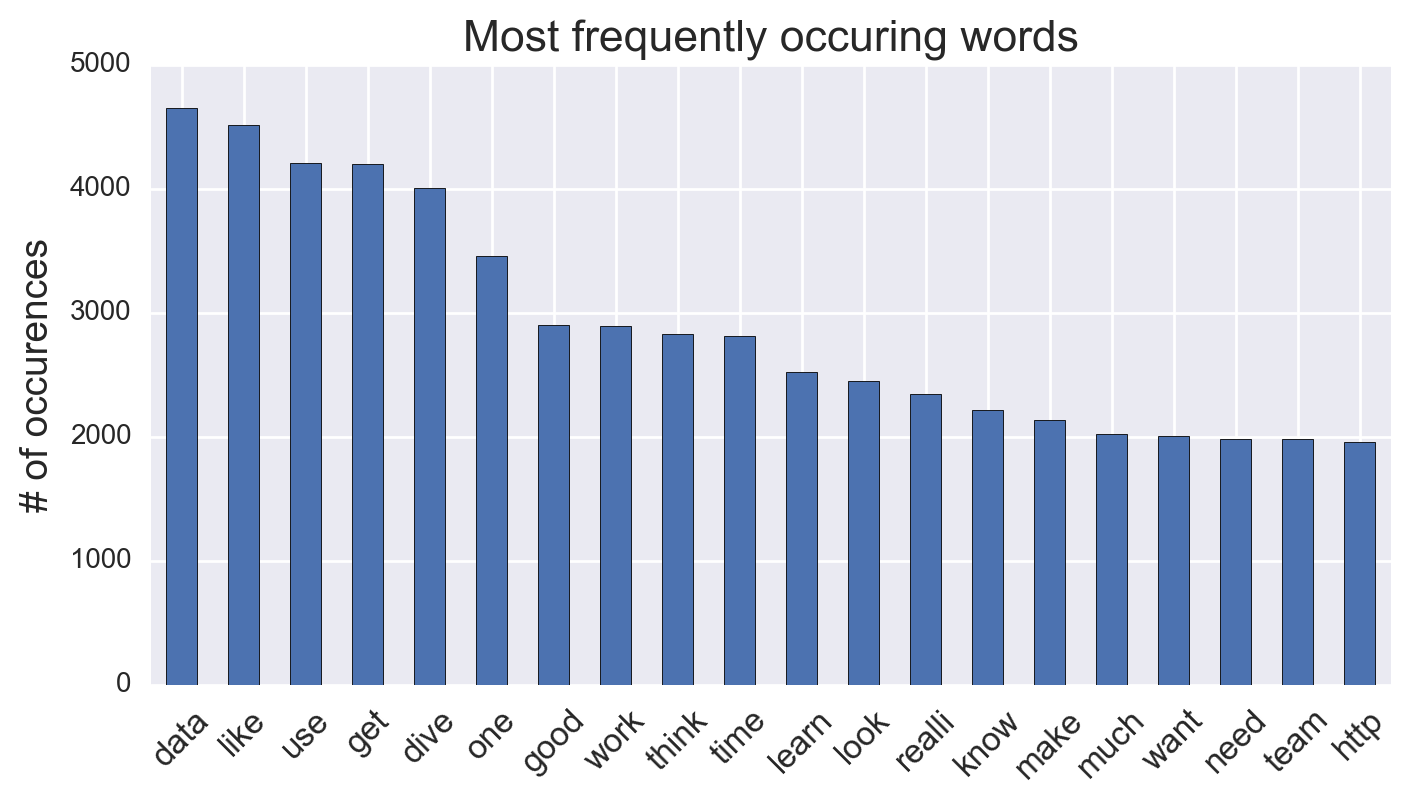

In [19]:
fig, ax = plt.subplots(figsize = (8, 4))
top_series[:20].plot.bar(ax = ax)
ax.set_xticklabels(top_series[:20].index.tolist(), rotation = 45, fontsize = 12)
ax.set_xlabel("", fontsize = 12)
ax.set_ylabel('# of occurences', fontsize = 14)
ax.set_title('Most frequently occuring words', fontsize = 16);

Let's look at most frequently occuring words in each subreddit:

In [20]:
freqs_list = []
for datum in data_clean:
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                                 preprocessor = None, stop_words = None, 
                                 max_features = 5000)
    this_bow = vectorizer.fit_transform(datum)
    this_bow_array = this_bow.toarray()
    vocabulary = vectorizer.get_feature_names()
    counts = np.sum(this_bow_array, axis = 0)
    top_words = pd.DataFrame({'word': vocabulary, 'count': counts}).sort_values(by = 'count', ascending = False)
    top_series = top_words['count']
    top_series.index = top_words['word']
    freqs_list.append(top_series)

Plot the relative frequencies:

In [21]:
rel_freq_list = [f / f.sum() for f in freqs_list]

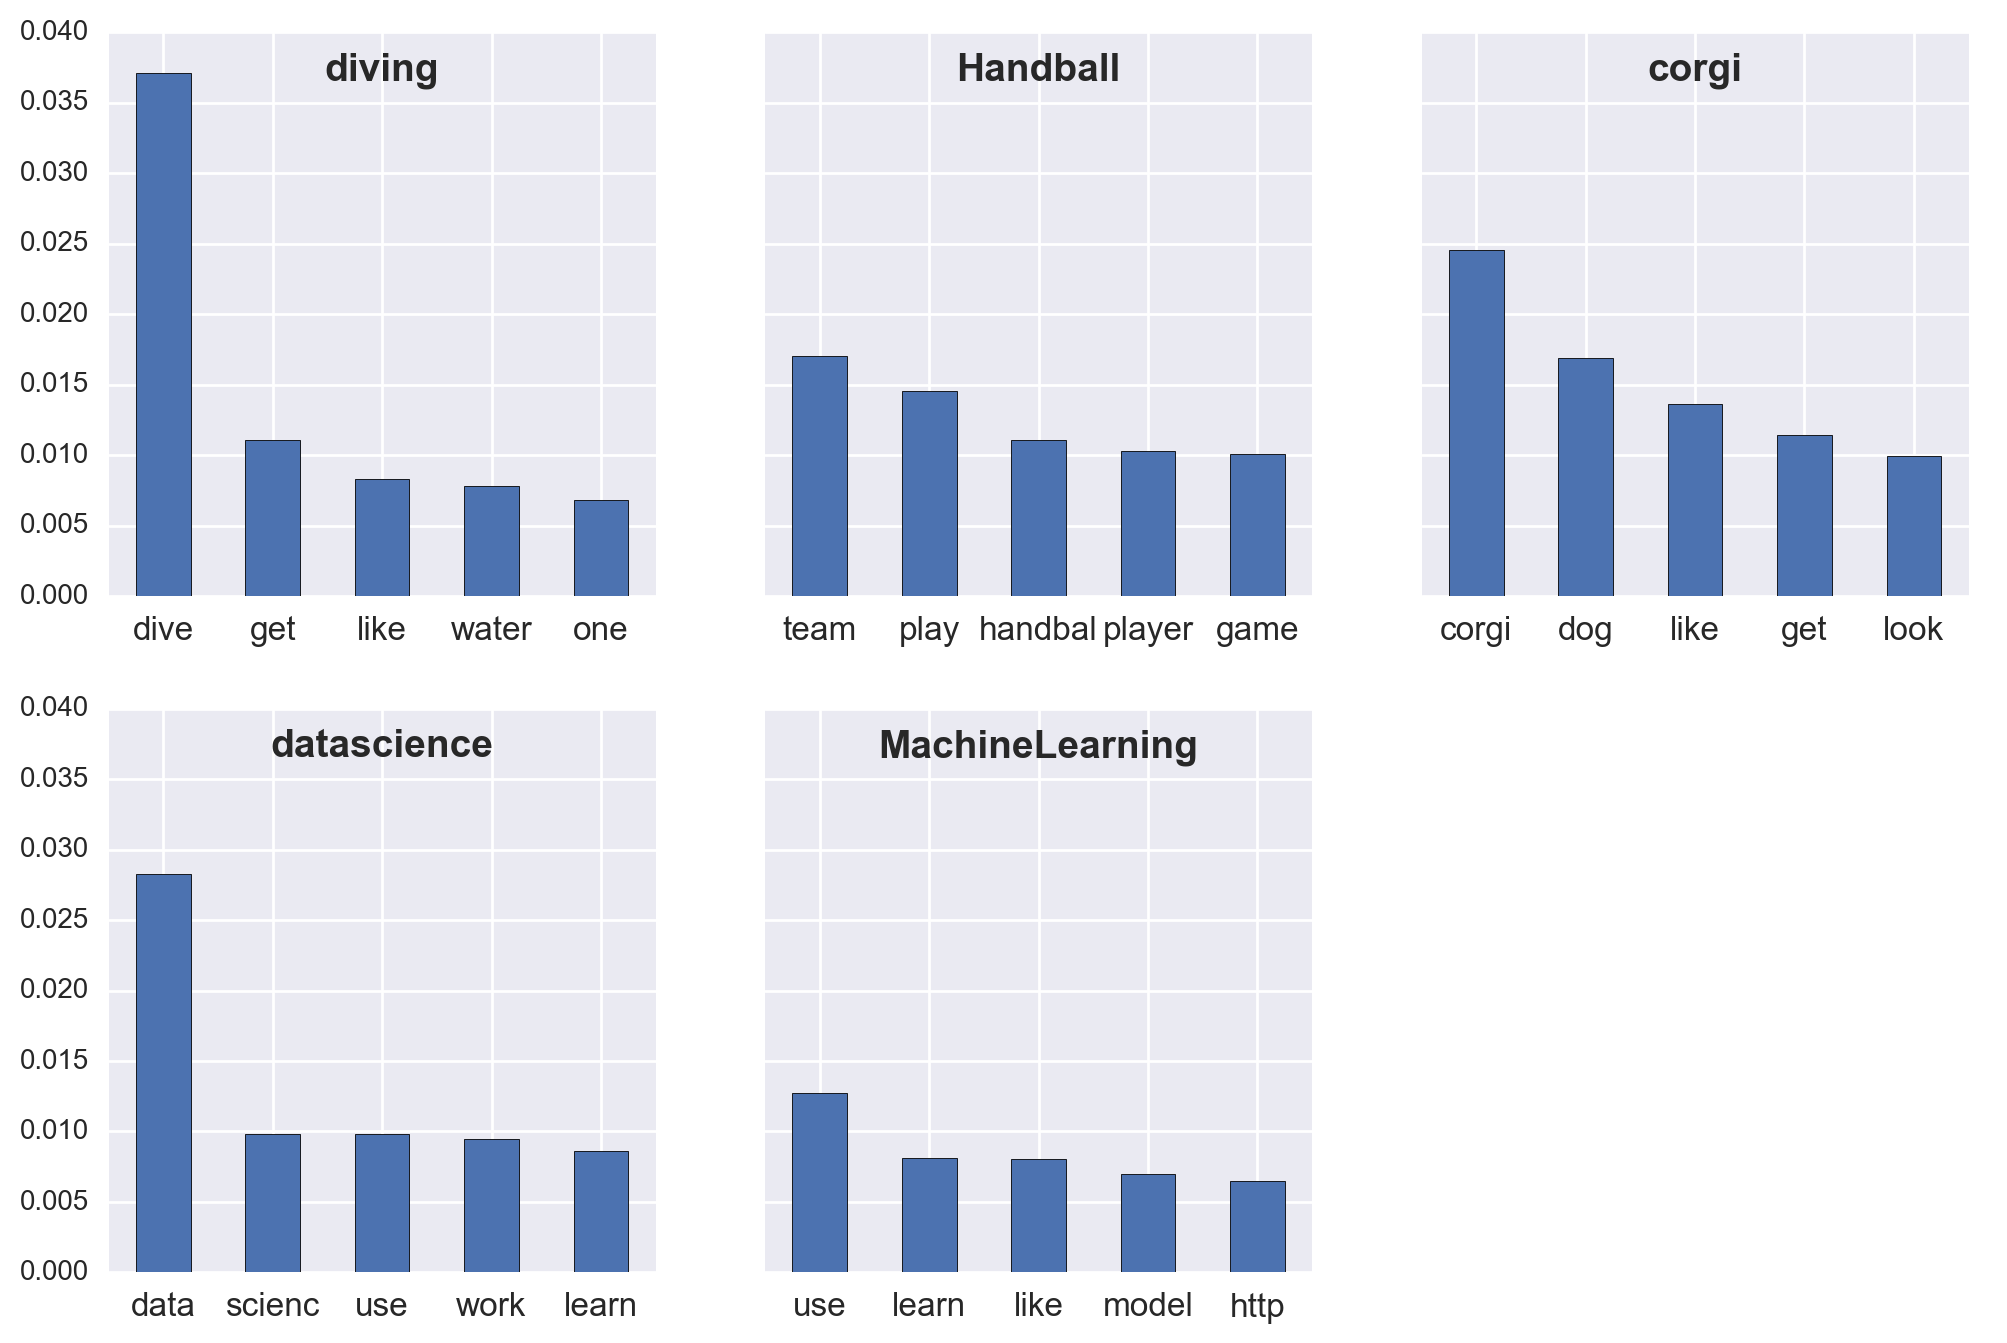

In [22]:
fig, axes = plt.subplots(2, 3, sharex = False, sharey = True, figsize = (12, 8))
cnt = 0
for i in range(2):
    for j in range(3):
        if cnt <= 4:
            rel_freq_list[cnt][:5].plot.bar(ax = axes[i, j])
            #axes[i, j].set_title(all_subreddit_names[cnt], fontweight="bold")
            axes[i, j].set_xticklabels(rel_freq_list[cnt][:5].index.tolist(), rotation = 0, fontsize = 12)
            axes[i, j].set_xlabel("", fontsize = 12)
            axes[i, j].text(0.5, 0.915, all_subreddit_names[cnt], fontweight="bold", fontsize =14, 
                            horizontalalignment = 'center', transform = axes[i, j].transAxes)
            cnt = cnt + 1
        else: 
            axes[i, j].axis('off')

In [21]:
fig.savefig('frequencies.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

Now, the idea is to generate TF-IDF from BOW and use a simple cosine similarity as a baby version of the full word2vec + WMD problem:

In [23]:
transformer = TfidfTransformer()
all_tfidf = transformer.fit_transform(all_bow_array)
cosine_similarities = linear_kernel(all_tfidf[0:1], all_tfidf).flatten()

---

# <a name="learning_curve">4. Generate the learning curve</a>

In this section, we'll vary the size of the training set, and for each size, we'll:
* Define the test (validation) set as some fraction of posts following the training set
* For each example in the test set, evaluate the cosine similarity with each example in the training set
* Calculate the average similarity for each subreddit and assign the subreddit with the larger similarity to the example in question
* Calculate the accuracy

Start by defining the training set sizes we'll consider:

In [24]:
test_size_fraction = 0.15

In [25]:
max_train_size = int(min(lengths) / (1 + test_size_fraction))
max_train_size

4353

In [26]:
start_size = 250
step_size = 250

Do what I just described:

In [34]:
accuracy_list = []
train_size_list = []
full_cnt = 1
for train_size in range(start_size, max_train_size, step_size): 
    output_string = ("\rStep " + str(full_cnt) + " / " + 
                     str(len(range(start_size, max_train_size, step_size))))
    sys.stdout.write(output_string)
    sys.stdout.flush()
    # Define the training and test sets
    test_size = int(test_size_fraction * train_size)
    train_clean = []
    for datum in data_clean:
        train_clean = train_clean + datum[0: train_size]
    test_clean = []
    for datum in data_clean:
        test_clean = test_clean + datum[train_size: train_size + test_size]    
    # Fit the BOW on the training set and transform the test set
    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                                 preprocessor = None, stop_words = None, 
                                 max_features = 5000) 
    train_bow = vectorizer.fit_transform(train_clean)
    test_bow = vectorizer.transform(test_clean)
    train_bow_array = train_bow.toarray()
    test_bow_array = test_bow.toarray()
    # Fit the TF-IDF on the training set and transform the test set
    transformer = TfidfTransformer()
    train_tfidf = transformer.fit_transform(train_bow_array)
    test_tfidf = transformer.transform(test_bow_array)
    # Calculate the similarities for each test example
    outcome = []
    for i in range(test_size * len(data_clean)):
        cosine_similarities = linear_kernel(test_tfidf[i], train_tfidf).flatten()
        sim_avgs = [cosine_similarities[s * train_size: (s + 1) * train_size].mean() for s in range(len(data))]
        index_max = sim_avgs.index(max(sim_avgs))
        outcome.append(all_subreddit_names[index_max])    
    # Calculate the accuracy
    correct_count = 0
    for s in range(len(data)):
        for o in outcome[s * test_size: (s + 1) * test_size]:
            if o == all_subreddit_names[s]: correct_count = correct_count + 1
    accuracy = correct_count / (test_size * len(data_clean))
    accuracy_list.append(accuracy)
    train_size_list.append(train_size)
    full_cnt = full_cnt + 1

Step 17 / 17

Plot the learning curve

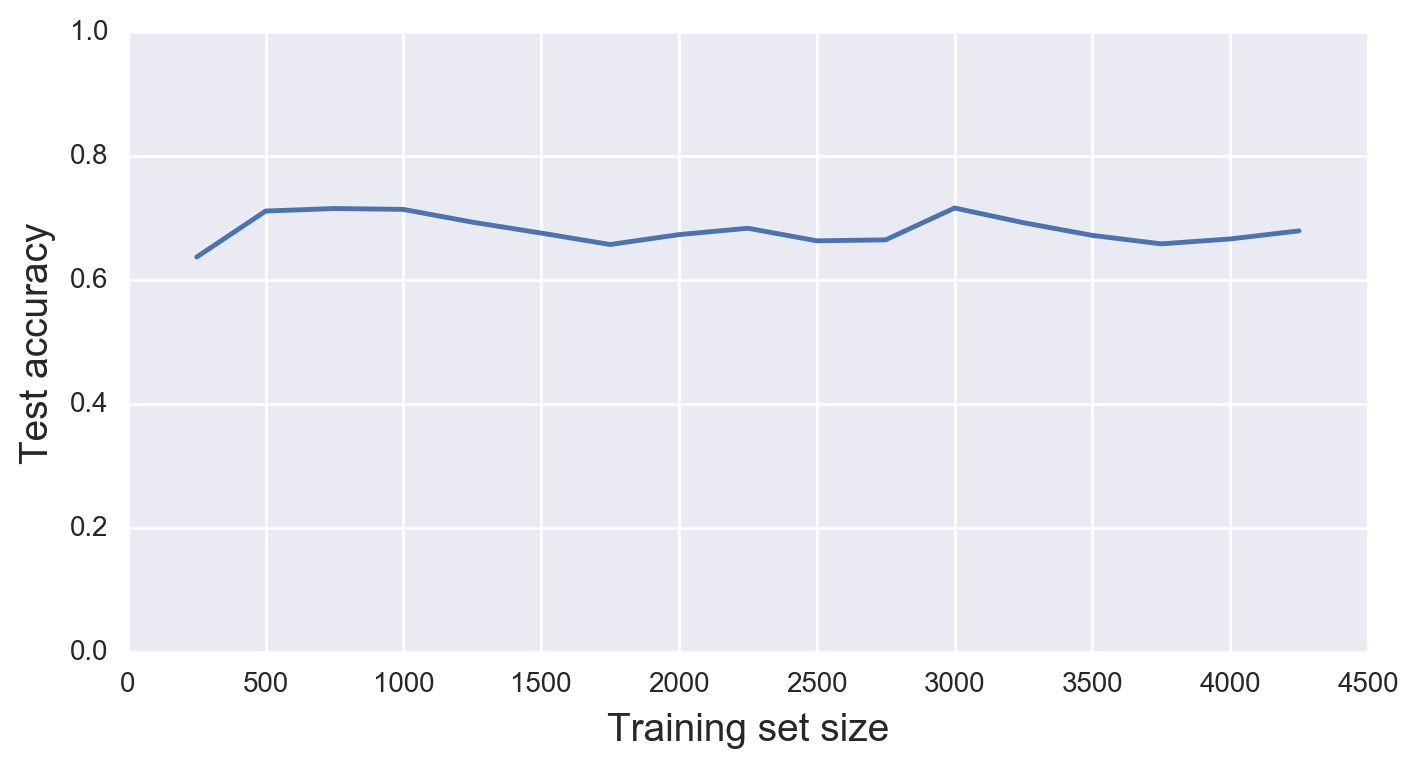

In [171]:
fig, ax = plt.subplots(figsize = (8, 4))
plt.plot(train_size_list, accuracy_list)
ax.set_xlabel("Training set size", fontsize = 14)
ax.set_ylabel('Test accuracy', fontsize = 14)
ax.set_ylim([0,1]);

In [172]:
fig.savefig('learning_curve.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

Visualize the confusion matrix

In [43]:
true_outcomes = []
for s in range(len(data)):
    true_outcomes = true_outcomes + test_size * [all_subreddit_names[s]]

In [94]:
conf_mat = confusion_matrix(true_outcomes, outcome)
conf_mat_rel = conf_mat / conf_mat.astype(np.float).sum(axis = 1)

In [100]:
conf_df = pd.DataFrame(conf_mat_rel * 100, index = all_subreddit_names, columns = all_subreddit_names)

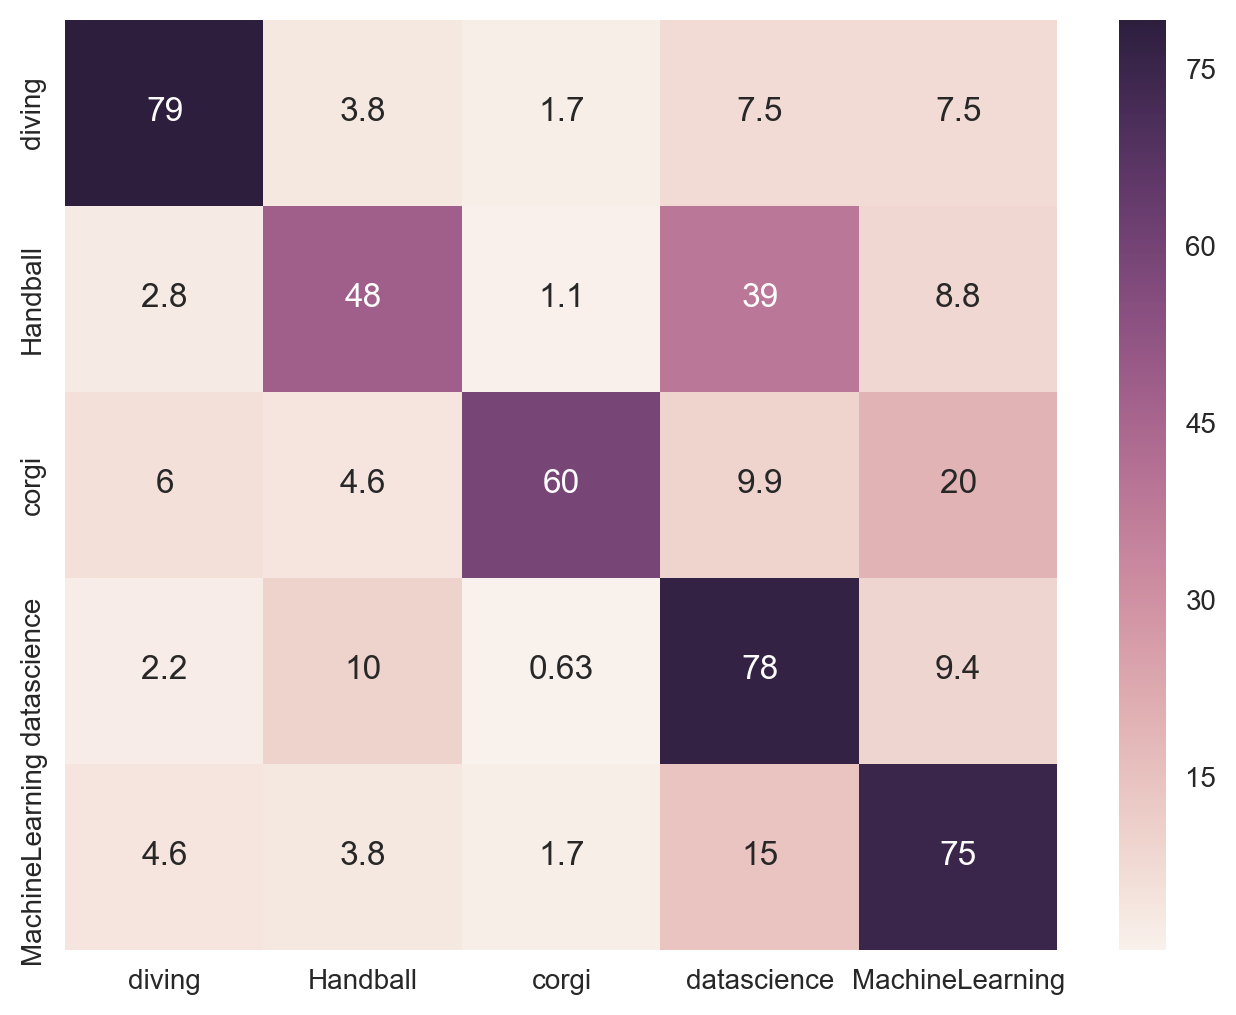

In [175]:
fig, ax = plt.subplots(figsize = (8, 6))
seaborn.heatmap(conf_df, annot = True, ax = ax);

In [176]:
fig.savefig('confusion_matrix.png', bbox_inches = 'tight', pad_inches = 0, dpi = 500, format = 'png')

In [92]:
con.close()

---

# <a name="slack_bot">5. Slackbot</a>

Our Slack officer is called Newman and here are his credentials:

In [27]:
bot_token = os.environ["SLACKBOT_TOKEN_NEWMAN"]
bot_name = 'officer_newman'

Initialize the Slack client and find out its ID (so we can filter its messages):

In [28]:
slack_client = SlackClient(bot_token)

In [29]:
users = slack_client.api_call("users.list").get('members')
for user in users:
    if 'name' in user and user.get('name') == bot_name:
        bot_id = user.get('id')
bot_id

u'U3WF8D4SX'

Let's train the BOW & TF-IDF on our entire training corpus again:

In [30]:
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None,    
                             preprocessor = None, stop_words = None, 
                             max_features = 5000) 
transformer = TfidfTransformer()

In [31]:
all_bow = vectorizer.fit_transform(all_clean)
all_bow_array = all_bow.toarray()
all_tfidf = transformer.fit_transform(all_bow_array)

Let's find the channel ID's:

In [32]:
channel_list = slack_client.api_call("channels.list")['channels']
[(c['id'], c['name']) for c in channel_list]

[(u'C3WJDNPCJ', u'ex1_diving'),
 (u'C3WJDPEHG', u'ex2_handball'),
 (u'C3WV35AEN', u'ex3_corgi'),
 (u'C3W93G2F3', u'ex4_data_science'),
 (u'C3XKZSM1V', u'ex5_machine_learning'),
 (u'C3UTPTUMT', u'general'),
 (u'C3UTDRVT6', u'random')]

Select the relevant ones:

In [33]:
all_subreddit_names

['diving', 'Handball', 'corgi', 'datascience', 'MachineLearning']

In [34]:
all_channel_ids = [c['id'] for c in channel_list if 'ex' in c['name']]
all_channel_names = [c['name'] for c in channel_list if 'ex' in c['name']]
print all_channel_names
print all_channel_ids

[u'ex1_diving', u'ex2_handball', u'ex3_corgi', u'ex4_data_science', u'ex5_machine_learning']
[u'C3WJDNPCJ', u'C3WJDPEHG', u'C3WV35AEN', u'C3W93G2F3', u'C3XKZSM1V']


This function will check if the output from Slack came from a user as a text message:

In [35]:
def parse_slack_output(slack_rtm_output):
    output_list = slack_rtm_output
    if output_list and len(output_list) > 0:
        for output in output_list:
            if output and 'text' in output and 'user' in output:
                return output['text'].strip().lower(), output['channel'], output['user']
    return None, None, None

If so, we then find the TF-IDF representation of the output and calculate the average similarity across channels. The one with the highest average similarity wins, and if the post was posted in a different channel, the bot posts the message indicating this.

In [36]:
indices = [0] * (len(data)+1)
for i in range(1, len(data)+1):
    indices[i] = indices[i-1] + len(data[i-1])

In [37]:
def handle_input(input_string, channel, user):
    # TF-IDF representation of the input
    input_tokenized = clean_post(input_string)
    input_clean = " ".join(input_tokenized)
    input_bow = vectorizer.transform([input_clean])
    input_bow_array = input_bow.toarray()
    input_tfidf = transformer.transform(input_bow_array)
    # Calculate the similarities and predict the channel  
    cosine_similarities = linear_kernel(input_tfidf, all_tfidf).flatten()
    sim_avgs = [cosine_similarities[indices[s]: indices[s + 1]].mean() for s in range(len(data))]
    index_max = sim_avgs.index(max(sim_avgs))
    predicted_channel = all_channel_ids[index_max]    
    # Check if you're in the right channel
    if predicted_channel != channel and user != bot_id:
        response = ("Hey <@" + user + ">, consider posting this in the <#" + 
                    predicted_channel + "> channel.")
        slack_client.api_call("chat.postMessage", channel = channel,
                              text = response, as_user = True)

Open the Slack RTM firehose:

In [38]:
if slack_client.rtm_connect():
    print("officer_newman connected and monitoring...")
    while True:
        command, channel, user = parse_slack_output(slack_client.rtm_read())
        if command and channel:
            handle_input(command, channel, user)
        time.sleep(1)
else:
    print("Connection failed.")

officer_newman connected and monitoring...


KeyboardInterrupt: 